### Importing libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
from pmdarima import auto_arima

### Reading the data

In [2]:
bus_acc = pd.read_excel("shared_data_read_only/Business Account.xlsx")
cons_price_idx = pd.read_excel("shared_data_read_only/consumer_price_index.xlsx")
contact = pd.read_excel("shared_data_read_only/Contacts.xlsx")
inv_opp = pd.read_excel("shared_data_read_only/Invoice and Opportunities.xlsx")
item_opp = pd.read_excel("shared_data_read_only/Items and Opportunities.xlsx")
non_stock_item = pd.read_excel("shared_data_read_only/Non-Stock Items.xlsx")
opp = pd.read_excel("shared_data_read_only/Opportunities.xlsx")

# Modeling total donations

### The ivoices and opportunities dataset

In [ ]:
inv_opp

### Construct a daily timeseries

In [14]:
# Collecting the daily amount of donations received
ts = inv_opp.groupby("Date").sum()["Amount"] 
ts.index = pd.to_datetime(ts.index)
ts.sort_index(inplace = True)

# Adding the missing dates (when the association doesn't receive donations)
start_date = ts.index.min()
end_date = ts.index.max()
date_range = pd.date_range(start=start_date, end=end_date)
ts = ts.reindex(date_range, fill_value=0).reset_index()

# Removing data before 2021 because the association did not have yet the register system before
mask = ts['index'].apply(lambda x:x.year > 2020)
ts = ts[mask].reset_index(drop = True)

In [17]:
ts.head(15)

,index,Amount
0,2021-01-01,0.0
1,2021-01-02,0.0
2,2021-01-03,0.0
3,2021-01-04,0.0
4,2021-01-05,0.0
5,2021-01-06,0.0
6,2021-01-07,20000.0
7,2021-01-08,0.0
8,2021-01-09,0.0
9,2021-01-10,0.0


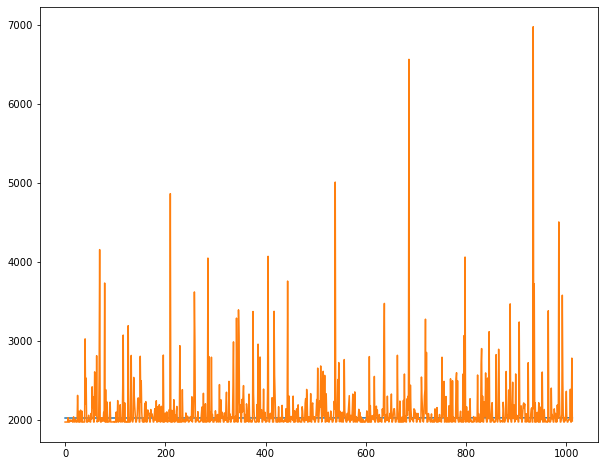

In [18]:
plt.figure(figsize = (10, 8))
plt.plot(ts)

In [19]:
# Removing weekends because the association received mostly no money on weekends
for index, row in ts.iterrows():
    date = row['index']
    is_weekend = date.weekday() >= 5
    if is_weekend:
         ts.drop(index, inplace=True)

### Checking if there is a relation between the days by ploting the data for each day of the week

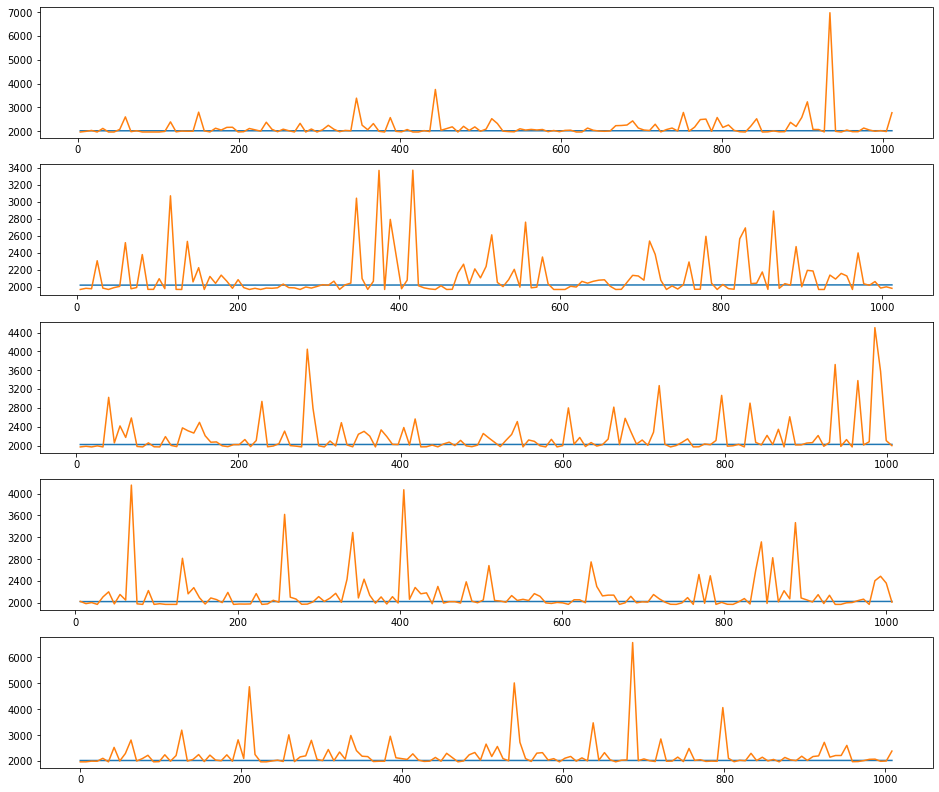

In [22]:
fig, axs = plt.subplots(5, figsize = (16, 14))
for i in range(5):
    mask_day = ts['index'].apply(lambda x: x.weekday() == i)
    days = ts[mask_day]
    axs[i].plot(days)
# But there is no apparent one

### Sarima model on daily time series

In [24]:
train_data = ts[ts['index'] < '2022-10-01']
test_data = ts[ts['index'] >= '2022-10-01']

In [25]:
# Finding optimal parameters
model1 = pm.auto_arima(train_data['Amount'])
model1

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

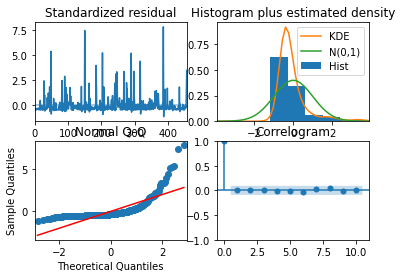

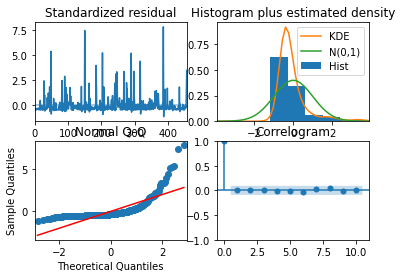

In [27]:
model1.plot_diagnostics()
# Residuals doesn't seem normalized

In [30]:
# Training a Sarima model with the found parameters
model2 = SARIMAX(train_data['Amount'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
results = model2.fit()
predictions = results.predict(start=len(train_data['Amount']), end=len(train_data['Amount']) + len(test_data) - 1, dynamic=False)

/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [31]:
# Errors
mse = mean_squared_error(test_data["Amount"], predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 44595753919.41999
RMSE: 211177.0676930144


In [ ]:
# Daily amounts seems a bit random, let's take a look at monthly amount received

### SARIMA model on monthly data

In [60]:
# Constructing the monthly time series
ts['index'] = pd.to_datetime(ts['index'])
filtered_dd = pd.DataFrame({'Date': ts['index'], 'Amount': ts['Amount']})
filtered_dd.set_index('Date', inplace=True)
monthly_sum = filtered_dd.resample('M').sum()
monthly_sum = monthly_sum[monthly_sum.index < '2023-10-01']

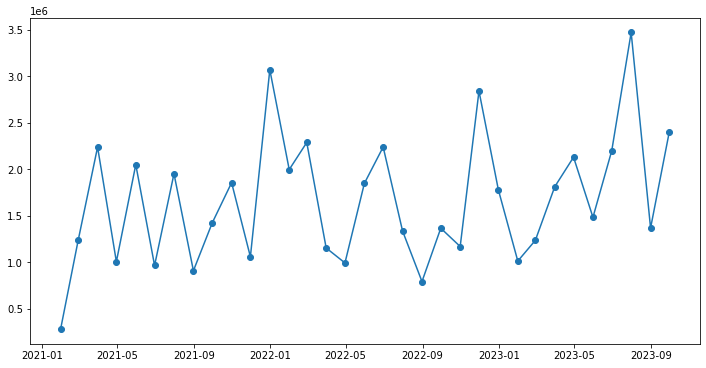

In [61]:
plt.figure(figsize =(12,6))
plt.plot(monthly_sum.index, monthly_sum.values, marker='o')

In [62]:
train_data = monthly_sum[monthly_sum.index < '2022-12-01']
test_data = monthly_sum[monthly_sum.index >= '2022-12-01']

/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/utils.py:120: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (11) is shorter than m (12). Using D=1
  % (len(x), m, D))


Performing stepwise search to minimize aic


/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=16.000, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=338.210, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=340.981, Time=0.01 sec


/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=14.000, Time=0.13 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=12.000, Time=0.08 sec


/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=14.000, Time=0.13 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=364.109, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=347.043, Time=0.05 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=14.000, Time=0.09 sec


/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,3)(0,1,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 515, in _fit_wrapper
    **fit_args,
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 709, in fit
    skip_h

 ARIMA(2,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=344.490, Time=0.05 sec
 ARIMA(1,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(0,1,0)[12] intercept   : AIC=347.419, Time=0.07 sec
 ARIMA(3,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=nan sec


/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,3)(0,1,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 515, in _fit_wrapper
    **fit_args,
  File "/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 709, in fit
    skip_h

 ARIMA(2,0,2)(0,1,0)[12]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,0,2)(0,1,0)[12] intercept
Total fit time: 1.566 seconds


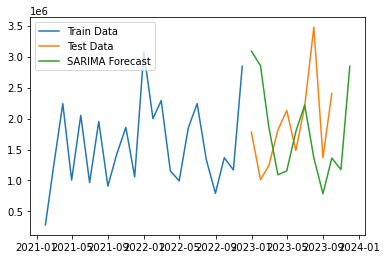

In [67]:
# Parameters selection
auto_model = auto_arima(train_data['Amount'], seasonal=True,m = 12, stepwise=True, trace=True)

# Get the recommended SARIMA order
p, d, q = auto_model.order
P, D, Q, S = auto_model.seasonal_order

# Training the SARIMA model
model = sm.tsa.statespace.SARIMAX(train_data['Amount'], order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Predictions
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
forecast_values = forecast.predicted_mean

# Plot the observed data and the forecasted values
plt.plot(train_data.index, train_data['Amount'], label='Train Data')
plt.plot(test_data.index, test_data['Amount'], label='Test Data')
plt.plot(forecast_values.index, forecast_values, label='SARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
# Predictions are acceptable
# Indeed, there is few training data and only few seasons (period 1 year)
# So we can suppose the predictions can be better using a traing on all the data we have

/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-user-3/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


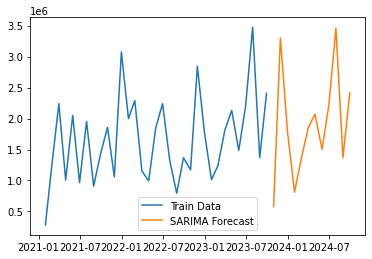

In [68]:
# Training the SARIMA model
model = sm.tsa.statespace.SARIMAX(monthly_sum['Amount'], order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Predictions
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
forecast_values = forecast.predicted_mean

# Plot the observed data and the forecasted values
plt.plot(monthly_sum.index, monthly_sum['Amount'], label='Train Data')
plt.plot(forecast_values.index, forecast_values, label='SARIMA Forecast')
plt.legend()
plt.show()